# (A) Dependencies

## Installation

In [13]:
!pip install git+https://github.com/huggingface/transformers.git
!pip install datasets
!pip install huggingface-hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-t0ujj25a
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-t0ujj25a
  Resolved https://github.com/huggingface/transformers.git to commit cae78c46d658a8e496a815c2ee49b9b178fb9c9a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.28.0.dev0-py3-none-any.whl size=6827740 sha256=33ff084430b372141f942c0ec5760f4def4bcc0a71de2183c6ba7e391c8337e5
  Stored in directory: /tmp/pip-ephem-wheel-cache-s04bncrx/wheels/f7/92/8c/752ff3bfcd3439805d8bbf641614da38ef3226e127ebea86ee
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.27.3
    Uninstalling t

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 16.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# (B) Dataset

## Loading the pre-studies (Optional)

```python
from google.colab import drive
drive.mount('/content/drive')
```

```python
!rm -r /content/fine_tuned_qa.zip
```

```python
!cp -r  /content/drive/MyDrive/Home/Projects/QuestionAnswer/fine_tuned_qa.zip fine_tuned_qa.zip 
```

```python
!unzip  /content/fine_tuned_qa.zip . 
```

```python
!mv /content/content/drive/MyDrive/Home/Projects/QuestionAnswering/fine_tuned_qa .
```
```python
!rm -r /content/content
```

## Loading the dataset

In [16]:
from datasets import load_dataset

datasets = load_dataset("squad")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Dataset squad downloaded and prepared to /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
print(datasets["train"][0])

{'id': '5733be284776f41900661182', 'title': 'University_of_Notre_Dame', 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.', 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}


# (C) Preprocessing

## Configurations

In [ ]:
# model hyperparams
max_length = 384  
doc_stride = 128


# model params
model_checkpoint = "distilbert-base-cased"
epochs = 5

## Tokenizer

In [ ]:
# Downloading the tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

## Implementing the preprocesses

### Util function

In [ ]:
def prepare_train_features(examples):
    # Tokenize our examples with truncation and padding, but keep the overflows using a
    # stride. This results in one example possible giving several features when a context is long,
    # each of those features having a context that overlaps a bit the context of the previous
    # feature.
    examples["question"] = [q.lstrip() for q in examples["question"]]
    examples["context"] = [c.lstrip() for c in examples["context"]]
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a
    # map from a feature to its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original
    # context. This will help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what
        # is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this
        # span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the
            # CLS index).
            if not (
                offsets[token_start_index][0] <= start_char
                and offsets[token_end_index][1] >= end_char
            ):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the
                # answer.
                # Note: we could go after the last offset if the answer is the last word (edge
                # case).
                while (
                    token_start_index < len(offsets)
                    and offsets[token_start_index][0] <= start_char
                ):
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

### Implementaiton

In [ ]:
tokenized_datasets = datasets.map(
    prepare_train_features,
    batched=True,
    remove_columns=datasets["train"].column_names,
    num_proc=3,
)

Map (num_proc=3):   0%|          | 0/87599 [00:00<?, ? examples/s]

Map (num_proc=3):   0%|          | 0/10570 [00:00<?, ? examples/s]

## Dataset Adjustments

In [ ]:
# type casting into numpy array
train_set = tokenized_datasets["train"].with_format("numpy")[:]  
validation_set = tokenized_datasets["validation"].with_format("numpy")[:]

# (D) Modelling

## Architecture

In [ ]:
# Downloading the model
from transformers import TFAutoModelForQuestionAnswering
#model = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint)
model = TFAutoModelForQuestionAnswering.from_pretrained("fine_tuned_qa")

All model checkpoint layers were used when initializing TFDistilBertForQuestionAnswering.

All the layers of TFDistilBertForQuestionAnswering were initialized from the model checkpoint at fine_tuned_qa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForQuestionAnswering for predictions without further training.


In [ ]:
import tensorflow as tf
from tensorflow import keras

# configurating the model
keras.mixed_precision.set_global_policy("mixed_float16")
optimizer = keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


## Training

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger,
                                        LearningRateScheduler, ReduceLROnPlateau, LambdaCallback)
import numpy as np

def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 5.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate

def print_current_lr(epoch, logs):
    print("Learning rate in epoch {} is {}".format(epoch, float(tf.keras.backend.get_value(model.optimizer.lr))))


# Temporary save paths
checkpoint_path = "fine_tuned_qa"
tb_log_dir = "./logs"

In [ ]:
callbacks = [
    #LearningRateScheduler(step_decay),
    TensorBoard(log_dir=tb_log_dir),
    ModelCheckpoint(filepath= checkpoint_path, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1),
    EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, restore_best_weights=True, verbose=1),
    CSVLogger(filename='training.log'),
    #LambdaCallback(on_epoch_end=print_current_lr)
]

In [ ]:
t_p = {
     "validation_data":validation_set, 
     "epochs":epochs, #5 
     "callbacks":callbacks
}

history = model.fit(train_set, **t_p)

Epoch 1/5
2773/2773 [==============================] - ETA: 0s - loss: 0.6772
Epoch 1: val_loss improved from inf to 1.23194, saving model to fine_tuned_qa
2773/2773 [==============================] - 3726s 1s/step - loss: 0.6772 - val_loss: 1.2319
Epoch 2/5
2773/2773 [==============================] - ETA: 0s - loss: 0.4992
Epoch 2: val_loss did not improve from 1.23194
2773/2773 [==============================] - 3755s 1s/step - loss: 0.4992 - val_loss: 1.3568
Epoch 3/5
2773/2773 [==============================] - ETA: 0s - loss: 0.3825
Epoch 3: val_loss did not improve from 1.23194
Restoring model weights from the end of the best epoch: 1.
2773/2773 [==============================] - 3751s 1s/step - loss: 0.3825 - val_loss: 1.5389
Epoch 3: early stopping


In [ ]:
validation_set

In [ ]:
examples = [
    validation_set[i]["document"]
    for i in range(5)
]

In [ ]:
import pickle

with open('examples.pkl', 'wb') as f: pickle.dump(examples, f)
with open('examples.pkl', 'rb') as f: loaded_examples = pickle.load(f)

In [ ]:
history.history

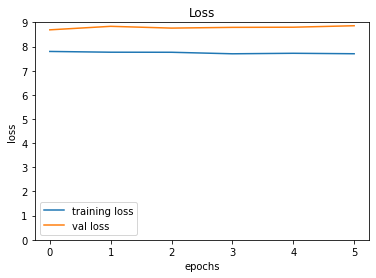

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim((0, 9))

plt.legend()

In [ ]:
loss =[1.5171, 0.9373, 0.6823, 0.5075, 0.3838]
val_loss = [1.1528, 1.1236, 1.12364, 1.1236, 1.5537]

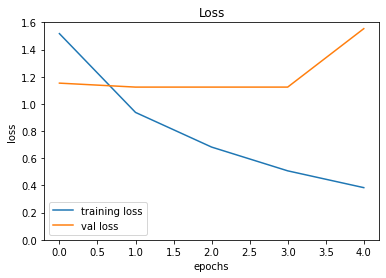

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss, label='training loss')
plt.plot(val_loss, label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim((0, 1.6))

plt.legend()

## prediction

In [ ]:
context = """Keras is an API designed for human beings, not machines. Keras follows best
practices for reducing cognitive load: it offers consistent & simple APIs, it minimizes
the number of user actions required for common use cases, and it provides clear &
actionable error messages. It also has extensive documentation and developer guides. """
question = "What is Keras?"

inputs = tokenizer([context], [question], return_tensors="np")
outputs = model(inputs)
start_position = tf.argmax(outputs.start_logits, axis=1)
end_position = tf.argmax(outputs.end_logits, axis=1)
print(int(start_position), int(end_position[0]))

26 12


In [ ]:
answer = inputs["input_ids"][0, int(start_position) : int(end_position) + 1]
print(answer)

[]


In [ ]:
print(tokenizer.decode(answer))

# (E) Saving the model

## Save the best model

In [ ]:
# Load the best weights
#model.load_weights(checkpoint_path)

In [ ]:
best_model_save_path = f"fine_tuned_qa_2" 
model.save_pretrained(best_model_save_path)

In [ ]:
tokenizer_save_path = "tokenizer_2"
tokenizer.save_pretrained(tokenizer_save_path)

('tokenizer_2/tokenizer_config.json',
 'tokenizer_2/special_tokens_map.json',
 'tokenizer_2/vocab.txt',
 'tokenizer_2/added_tokens.json',
 'tokenizer_2/tokenizer.json')

## Compressing the model

In [ ]:
dst, src = f"{best_model_save_path}.zip", best_model_save_path

In [ ]:
import os 
# Zipping the model to download
os.system(f"zip -r {dst} {src}")

0

In [ ]:
os.system(f"zip -r tokenizer.zip tokenizer")

3072

## Download the model

In [ ]:
# Downloading the zipped model into the local
from google.colab import files
files.download(dst)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount("drive")

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
!cp -r /content/fine_tuned_qa_2 /content/drive/MyDrive/Home/Projects/QuestionAnswer

In [ ]:
files.download("tokenizer.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!cp -r /content/tokenizer_2 /content/drive/MyDrive/Home/Projects/QuestionAnswer

## Saving the examples for demo app

In [17]:
examples = [
    [
        datasets["train"][i]["context"],
        datasets["train"][i]["question"],
        datasets["train"][i]["answers"]["text"][0]
    ]  for i in range(5)
]


In [18]:
import pickle

with open("examples.pkl","wb") as f: pickle.dump(examples,f)
with open("examples.pkl","rb") as f: loaded_examoles = pickle.load(f)

In [19]:
loaded_examoles

[['Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
  'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
  'Saint Bernadette Soubirous'],
 ['Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it,

# (F) Deployment as App

## APP (loading from file)

### Declerations & Util Funcs

In [1]:
import os
if os.system("pip freeze | grep gradio==") != 0: os.system("pip install gradio")
if os.system("pip freeze | grep transformers==") != 0: os.system("pip install transformers")

In [2]:
import tensorflow as tf
import transformers
import gradio as gr
import numpy as np
import pickle

In [3]:
from google.colab import drive
drive.mount("drive")

Mounted at drive


In [4]:
os.system("cp -r /content/drive/MyDrive/Home/Projects/QuestionAnswer/fine_tuned_qa .")
os.system("cp -r /content/drive/MyDrive/Home/Projects/QuestionAnswer/tokenizer .")

0

In [5]:
from transformers import AutoTokenizer, TFAutoModelForQuestionAnswering, pipeline

# File Paths
model_path = 'fine_tuned_qa' 
tokenizer_path = "tokenizer"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

# Load the fine-tuned BERT model
seq2seq_model = TFAutoModelForQuestionAnswering.from_pretrained(model_path)

# Creating the pipeline
qa_params = {
    "model":seq2seq_model,
    "tokenizer":tokenizer,
    "framework":"tf"
}

qa_pipeline = pipeline("question-answering", **qa_params)


# loading the example cases to test
with open("examples.pkl","rb") as f: examples = pickle.load(f)

All model checkpoint layers were used when initializing TFDistilBertForQuestionAnswering.

All the layers of TFDistilBertForQuestionAnswering were initialized from the model checkpoint at fine_tuned_qa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForQuestionAnswering for predictions without further training.


In [6]:
# Define a function to make predictions with the model
def answear_question(text,question):

    # defining the params
    prms = {
        "min_length":5,
        "max_length":128
    }
    return qa_pipeline(text, question,**prms)["answer"]

In [7]:
context = """Keras is an API designed for human beings, not machines. Keras follows best
practices for reducing cognitive load: it offers consistent & simple APIs, it minimizes
the number of user actions required for common use cases, and it provides clear &
actionable error messages. It also has extensive documentation and developer guides. """
question = "What is Keras?"

In [8]:
answear_question(context, question)

'Keras'

### Text Summarizer app

In [9]:
import gradio as gr


with gr.Blocks() as demo:
    context = gr.Textbox(label="context")
    question = gr.Textbox(label="question")
    act_ans = gr.Textbox(label="actual answer")
    gen_ans = gr.Button("Generate Answer")
    pred_ans = gr.Textbox(label="predicted answer")
    
    gen_ans.click(fn=answear_question, inputs=[context, question], outputs=pred_ans)

    gr.Examples(examples, inputs=[context, question,act_ans])

demo.launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>